In [1]:
from google.colab import drive
import os

# Mount Google Drive

drive.mount("/content/drive", force_remount=True)

%cd "/content/drive/MyDrive/Selected_Topics_HW4/"

Mounted at /content/drive
/content/drive/MyDrive/Selected_Topics_HW4


In [2]:
# note: this cell should only be run once
# Extract training and validation data

#!unzip "/content/drive/MyDrive/Selected_Topics_HW4/hw4_realse_dataset.zip" -d "/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/"

In [3]:
!ls

 checkpoint_1.pth	  train_loss_1.png   valid_loss_2.png
 checkpoint_2.pth	  train_loss_2.png   valid_loss_3.png
 checkpoint_NEW.pth	  train_loss_3.png   valid_loss_4.png
 checkpoint.pth		  train_loss_4.png   valid_loss_5.png
 example_img2npz.py	  train_loss_5.png   valid_loss_6.png
 hw4_realse_dataset.zip   train_loss_6.png   valid_loss_7.png
 hw4_release_dataset	  train_loss_7.png   valid_loss.png
'pred(2).npz'		  train_loss.png    'Новая презентация.gslides'
 ST_HW4.ipynb		  valid_loss_1.png  'Новый документ.gdoc'


In [4]:
import glob as glob
import re

def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(data, key=alphanum_key)


root_dir = os.path.join(os.getcwd())
print(root_dir)
DIR_TRAIN_CLEAN = root_dir + "/hw4_release_dataset/hw4_realse_dataset/train/clean"
DIR_TRAIN_DEGRADED = root_dir + "/hw4_release_dataset/hw4_realse_dataset/train/degraded"
DIR_TEST = root_dir + "/hw4_release_dataset/hw4_realse_dataset/test/degraded"

train_clean_images = glob.glob(f"{DIR_TRAIN_CLEAN}/*.png")
train_degraded_images = glob.glob(f"{DIR_TRAIN_DEGRADED}/*.png")
test_images = glob.glob(f"{DIR_TEST}/*.png")

train_clean_images = sorted_alphanumeric(train_clean_images)
train_degraded_images = sorted_alphanumeric(train_degraded_images)
test_images = sorted_alphanumeric(test_images)

train_clean_num = len(train_clean_images)
train_degraded_num = len(train_degraded_images)
test_num = len(test_images)

print(f"Clean train instances: {train_clean_num}")
print(f"Degraded train instances: {train_degraded_num}")
print(f"Degraded test instances: {test_num}")
print(train_clean_images)

/content/drive/MyDrive/Selected_Topics_HW4
Clean train instances: 3200
Degraded train instances: 3200
Degraded test instances: 100
['/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/train/clean/rain_clean-1.png', '/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/train/clean/rain_clean-2.png', '/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/train/clean/rain_clean-3.png', '/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/train/clean/rain_clean-4.png', '/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/train/clean/rain_clean-5.png', '/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/train/clean/rain_clean-6.png', '/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/train/clean/rain_clean-7.png', '/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_re

# Utils

In [5]:
# create dataset for snow and rain noise

import os
import random
import copy
from PIL import Image
import numpy as np

from torch.utils.data import Dataset
from torchvision.transforms import ToPILImage, Compose, RandomCrop, ToTensor
import torch
import matplotlib.pyplot as plt

def crop_patch(im, pch_size):
    H = im.shape[0]
    W = im.shape[1]
    ind_H = random.randint(0, H - pch_size)
    ind_W = random.randint(0, W - pch_size)
    pch = im[ind_H:ind_H + pch_size, ind_W:ind_W + pch_size]
    return pch


# crop an image to the multiple of base
def crop_img(image, base=64):
    h = image.shape[0]
    w = image.shape[1]
    crop_h = h % base
    crop_w = w % base
    return image[crop_h // 2:h - crop_h + crop_h // 2, crop_w // 2:w - crop_w + crop_w // 2, :]


class PromptTrainDataset(Dataset):
    def __init__(self, train_data_file_dir, patch_size, de_type = ['derain', 'desnow']):
        super(PromptTrainDataset, self).__init__()

        self.snow_ids = []
        self.rain_ids = []

        self.train_data_file_dir = train_data_file_dir
        self.patch_size = patch_size
        self.de_temp = 0
        self.de_type = de_type
        print(self.de_type)
        self.de_dict = {'derain': 0, 'desnow': 1}

        self._init_ids()
        self._merge_ids()

        self.crop_transform = Compose([
            ToPILImage(),
            RandomCrop(patch_size),
        ])

        self.toTensor = ToTensor()

    def _init_ids(self):
        if 'desnow' in self.de_type:
            self._init_snow_ids()
        if 'derain' in self.de_type:
            self._init_rain_ids()

        random.shuffle(self.de_type)

    def _init_rain_ids(self):
        temp_ids = list(range(1, 1601))
        self.rain_ids = [{"clean_id" : x, "de_type" : 0} for x in temp_ids]
        self.rain_counter = 0

        self.num_rain = len(self.rain_ids)
        print("Total Rain Ids : {}".format(self.num_rain))

    def _init_snow_ids(self):
        temp_ids = list(range(1601, 3201))
        self.snow_ids = [{"clean_id" : x,"de_type" : 1} for x in temp_ids]

        self.snow_counter = 0
        self.num_snow = len(self.snow_ids)
        print("Total Snow Ids : {}".format(self.num_snow))



    def _crop_patch(self, img_1, img_2):
        H = img_1.shape[0]
        W = img_1.shape[1]
        ind_H = random.randint(0, H - self.patch_size)
        ind_W = random.randint(0, W - self.patch_size)

        patch_1 = img_1[ind_H:ind_H + self.patch_size, ind_W:ind_W + self.patch_size]
        patch_2 = img_2[ind_H:ind_H + self.patch_size, ind_W:ind_W + self.patch_size]

        return patch_1, patch_2

    def _merge_ids(self):
        self.sample_ids = []
        if "derain" in self.de_type:
            self.sample_ids+= self.rain_ids
        if "desnow" in self.de_type:
            self.sample_ids+= self.snow_ids
        print(len(self.sample_ids))

    def __getitem__(self, idx):

        sample = self.sample_ids[idx]
        de_id = sample["de_type"]

        if de_id == 0:
            # Rain Streak Removal
            degraded_image_path = self.train_data_file_dir + "degraded/rain-" + str(sample["clean_id"]) + ".png"
            image_path = self.train_data_file_dir + "clean/rain_clean-" + str(sample["clean_id"]) + ".png"
            degrad_img = crop_img(np.array(Image.open(degraded_image_path).convert('RGB')), base=16)
            clean_name = "rain_clean-" + str(sample["clean_id"]) + ".png"
            clean_img = crop_img(np.array(Image.open(image_path).convert('RGB')), base=16)

        elif de_id == 1:
            # Snow removal
            true_id = sample["clean_id"] - 1600
            degraded_image_path = self.train_data_file_dir + "degraded/snow-" + str(true_id) + ".png"
            image_path = self.train_data_file_dir + "clean/snow_clean-" + str(true_id) + ".png"
            degrad_img = crop_img(np.array(Image.open(degraded_image_path).convert('RGB')), base=16)
            clean_name = "snow_clean-" + str(true_id) + ".png"
            clean_img = crop_img(np.array(Image.open(image_path).convert('RGB')), base=16)

        degrad_patch, clean_patch = self._crop_patch(degrad_img, clean_img)

        clean_patch = self.toTensor(clean_patch)
        degrad_patch = self.toTensor(degrad_patch)


        return [clean_name, de_id], degrad_patch, clean_patch

    def __len__(self):
        return len(self.sample_ids)

/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/train/
['derain', 'desnow']
Total Snow Ids : 1600
Total Rain Ids : 1600
3200
3200
training set size:  2880
validation set size:  320
Length of train loader  720
Length of val loader  80
torch.Size([4, 3, 128, 128])
torch.Size([4, 3, 128, 128])
Clean patch max: 1.0 and min 0.10588235408067703
degrad patch max: 1.0 and min 0.20000000298023224


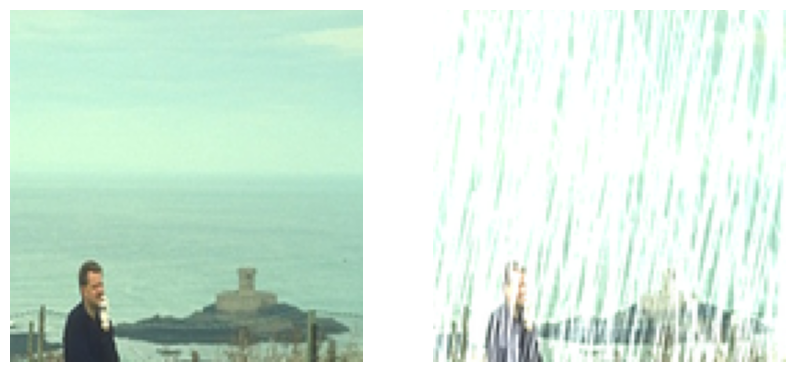

In [14]:
import torch
import torchvision.utils
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

train_data_dir = root_dir + "/hw4_release_dataset/hw4_realse_dataset/train/"
print(train_data_dir)
dataset = PromptTrainDataset(train_data_file_dir=train_data_dir, patch_size = 128, de_type = ['derain', 'desnow'])

BATCH_SIZE = 4
print(len(dataset))
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
print("training set size: ", train_size)
print("validation set size: ", val_size)

# Split the dataset
train_dataset, valid_dataset = random_split(dataset, [train_size, val_size])

dataloaders = {
  'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0),
  'val': DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
}

print("Length of train loader ", len(dataloaders['train']))
print("Length of val loader ", len(dataloaders['val']))

[clean_name, de_id], degrad_patch, clean_patch = next(iter(dataloaders['train']))

print(degrad_patch.shape)
print(clean_patch.shape)
one_degrad = degrad_patch[0].numpy()
one_clean = clean_patch[0].numpy()
print(f"Clean patch max: {np.max(one_clean)} and min {np.min(one_clean)}")
print(f"degrad patch max: {np.max(one_degrad)} and min {np.min(one_degrad)}")
one_degrad = one_degrad.transpose(1,2,0)
one_clean = one_clean.transpose(1,2,0)

f, axarr = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axarr[0].imshow(one_clean)
axarr[0].axis("off")
axarr[1].imshow(one_degrad)
axarr[1].axis("off")
plt.show()



Data max: 255 and min 0


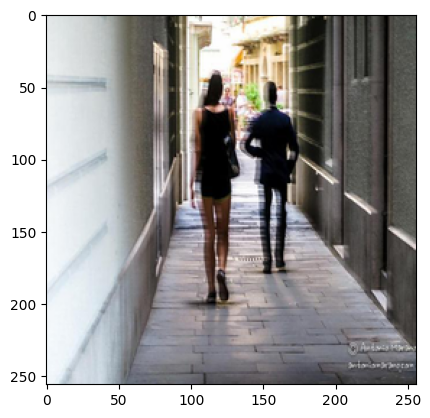

Data max: 255 and min 0


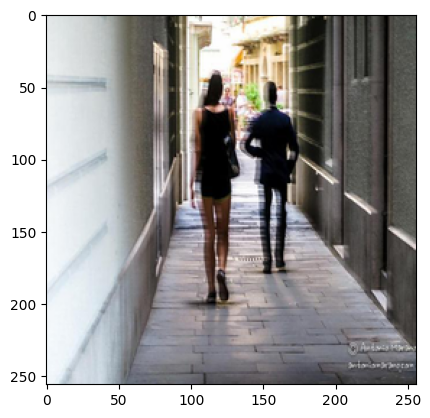

In [15]:
import matplotlib.pyplot as plt

img_path = "/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/train/clean/snow_clean-779.png"
img = crop_img(np.array(Image.open(img_path).convert('RGB')), base=16)
print(f"Data max: {np.max(img)} and min {np.min(img)}")
plt.imshow(img)
plt.show()

img_path = "/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/train/clean/snow_clean-779.png"
img = Image.open(img_path).convert('RGB')
print(f"Data max: {np.max(img)} and min {np.min(img)}")
plt.imshow(img)
plt.show()


# Model Definition

In [16]:
## PromptIR: Prompting for All-in-One Blind Image Restoration
## Vaishnav Potlapalli, Syed Waqas Zamir, Salman Khan, and Fahad Shahbaz Khan
## https://arxiv.org/abs/2306.13090


import torch
# print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
from pdb import set_trace as stx
import numbers

from einops import rearrange
from einops.layers.torch import Rearrange
import time


##########################################################################
## Layer Norm

def to_3d(x):
    return rearrange(x, 'b c h w -> b (h w) c')

def to_4d(x,h,w):
    return rearrange(x, 'b (h w) c -> b c h w',h=h,w=w)

class BiasFree_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(BiasFree_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return x / torch.sqrt(sigma+1e-5) * self.weight


class WithBias_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(WithBias_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        mu = x.mean(-1, keepdim=True)
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return (x - mu) / torch.sqrt(sigma+1e-5) * self.weight + self.bias


class LayerNorm(nn.Module):
    def __init__(self, dim, LayerNorm_type):
        super(LayerNorm, self).__init__()
        if LayerNorm_type =='BiasFree':
            self.body = BiasFree_LayerNorm(dim)
        else:
            self.body = WithBias_LayerNorm(dim)

    def forward(self, x):
        h, w = x.shape[-2:]
        return to_4d(self.body(to_3d(x)), h, w)



##########################################################################
## Gated-Dconv Feed-Forward Network (GDFN)
class FeedForward(nn.Module):
    def __init__(self, dim, ffn_expansion_factor, bias):
        super(FeedForward, self).__init__()

        hidden_features = int(dim*ffn_expansion_factor)

        self.project_in = nn.Conv2d(dim, hidden_features*2, kernel_size=1, bias=bias)

        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2, bias=bias)

        self.project_out = nn.Conv2d(hidden_features, dim, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.project_in(x)
        x1, x2 = self.dwconv(x).chunk(2, dim=1)
        x = F.gelu(x1) * x2
        x = self.project_out(x)
        return x



##########################################################################
## Multi-DConv Head Transposed Self-Attention (MDTA)
class Attention(nn.Module):
    def __init__(self, dim, num_heads, bias):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))

        self.qkv = nn.Conv2d(dim, dim*3, kernel_size=1, bias=bias)
        self.qkv_dwconv = nn.Conv2d(dim*3, dim*3, kernel_size=3, stride=1, padding=1, groups=dim*3, bias=bias)
        self.project_out = nn.Conv2d(dim, dim, kernel_size=1, bias=bias)



    def forward(self, x):
        b,c,h,w = x.shape

        qkv = self.qkv_dwconv(self.qkv(x))
        q,k,v = qkv.chunk(3, dim=1)

        q = rearrange(q, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        k = rearrange(k, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        v = rearrange(v, 'b (head c) h w -> b head c (h w)', head=self.num_heads)

        q = torch.nn.functional.normalize(q, dim=-1)
        k = torch.nn.functional.normalize(k, dim=-1)

        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)

        out = (attn @ v)

        out = rearrange(out, 'b head c (h w) -> b (head c) h w', head=self.num_heads, h=h, w=w)

        out = self.project_out(out)
        return out



class resblock(nn.Module):
    def __init__(self, dim):

        super(resblock, self).__init__()
        # self.norm = LayerNorm(dim, LayerNorm_type='BiasFree')

        self.body = nn.Sequential(nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PReLU(),
                                  nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, bias=False))

    def forward(self, x):
        res = self.body((x))
        res += x
        return res


##########################################################################
## Resizing modules
class Downsample(nn.Module):
    def __init__(self, n_feat):
        super(Downsample, self).__init__()

        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat//2, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelUnshuffle(2))

    def forward(self, x):
        return self.body(x)

class Upsample(nn.Module):
    def __init__(self, n_feat):
        super(Upsample, self).__init__()

        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat*2, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelShuffle(2))

    def forward(self, x):
        return self.body(x)


##########################################################################
## Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, ffn_expansion_factor, bias, LayerNorm_type):
        super(TransformerBlock, self).__init__()

        self.norm1 = LayerNorm(dim, LayerNorm_type)
        self.attn = Attention(dim, num_heads, bias)
        self.norm2 = LayerNorm(dim, LayerNorm_type)
        self.ffn = FeedForward(dim, ffn_expansion_factor, bias)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))

        return x



##########################################################################
## Overlapped image patch embedding with 3x3 Conv
class OverlapPatchEmbed(nn.Module):
    def __init__(self, in_c=3, embed_dim=48, bias=False):
        super(OverlapPatchEmbed, self).__init__()

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, x):
        x = self.proj(x)

        return x




##########################################################################
##---------- Prompt Gen Module -----------------------
class PromptGenBlock(nn.Module):
    def __init__(self,prompt_dim=128,prompt_len=5,prompt_size = 96,lin_dim = 192):
        super(PromptGenBlock,self).__init__()
        self.prompt_param = nn.Parameter(torch.rand(1,prompt_len,prompt_dim,prompt_size,prompt_size))
        self.linear_layer = nn.Linear(lin_dim,prompt_len)
        self.conv3x3 = nn.Conv2d(prompt_dim,prompt_dim,kernel_size=3,stride=1,padding=1,bias=False)


    def forward(self,x):
        B,C,H,W = x.shape
        emb = x.mean(dim=(-2,-1))
        prompt_weights = F.softmax(self.linear_layer(emb),dim=1)
        prompt = prompt_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) * self.prompt_param.unsqueeze(0).repeat(B,1,1,1,1,1).squeeze(1)
        prompt = torch.sum(prompt,dim=1)
        prompt = F.interpolate(prompt,(H,W),mode="bilinear")
        prompt = self.conv3x3(prompt)

        return prompt





##########################################################################
##---------- PromptIR -----------------------

class PromptIR(nn.Module):
    def __init__(self,
        inp_channels=3,
        out_channels=3,
        dim = 48,
        num_blocks = [4,6,6,8],
        num_refinement_blocks = 4,
        heads = [1,2,4,8],
        ffn_expansion_factor = 2.66,
        bias = False,
        LayerNorm_type = 'WithBias',   ## Other option 'BiasFree'
        decoder = False,
    ):

        super(PromptIR, self).__init__()

        self.patch_embed = OverlapPatchEmbed(inp_channels, dim)


        self.decoder = decoder

        if self.decoder:
            self.prompt1 = PromptGenBlock(prompt_dim=64,prompt_len=5,prompt_size = 64,lin_dim = 96)
            self.prompt2 = PromptGenBlock(prompt_dim=128,prompt_len=5,prompt_size = 32,lin_dim = 192)
            self.prompt3 = PromptGenBlock(prompt_dim=320,prompt_len=5,prompt_size = 16,lin_dim = 384)


        self.chnl_reduce1 = nn.Conv2d(64,64,kernel_size=1,bias=bias)
        self.chnl_reduce2 = nn.Conv2d(128,128,kernel_size=1,bias=bias)
        self.chnl_reduce3 = nn.Conv2d(320,256,kernel_size=1,bias=bias)



        self.reduce_noise_channel_1 = nn.Conv2d(dim + 64,dim,kernel_size=1,bias=bias)
        self.encoder_level1 = nn.Sequential(*[TransformerBlock(dim=dim, num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[0])])

        self.down1_2 = Downsample(dim) ## From Level 1 to Level 2

        self.reduce_noise_channel_2 = nn.Conv2d(int(dim*2**1) + 128,int(dim*2**1),kernel_size=1,bias=bias)
        self.encoder_level2 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**1), num_heads=heads[1], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[1])])

        self.down2_3 = Downsample(int(dim*2**1)) ## From Level 2 to Level 3

        self.reduce_noise_channel_3 = nn.Conv2d(int(dim*2**2) + 256,int(dim*2**2),kernel_size=1,bias=bias)
        self.encoder_level3 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**2), num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[2])])

        self.down3_4 = Downsample(int(dim*2**2)) ## From Level 3 to Level 4
        self.latent = nn.Sequential(*[TransformerBlock(dim=int(dim*2**3), num_heads=heads[3], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[3])])

        self.up4_3 = Upsample(int(dim*2**2)) ## From Level 4 to Level 3
        self.reduce_chan_level3 = nn.Conv2d(int(dim*2**1)+192, int(dim*2**2), kernel_size=1, bias=bias)
        self.noise_level3 = TransformerBlock(dim=int(dim*2**2) + 512, num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type)
        self.reduce_noise_level3 = nn.Conv2d(int(dim*2**2)+512,int(dim*2**2),kernel_size=1,bias=bias)


        self.decoder_level3 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**2), num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[2])])


        self.up3_2 = Upsample(int(dim*2**2)) ## From Level 3 to Level 2
        self.reduce_chan_level2 = nn.Conv2d(int(dim*2**2), int(dim*2**1), kernel_size=1, bias=bias)
        self.noise_level2 = TransformerBlock(dim=int(dim*2**1) + 224, num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type)
        self.reduce_noise_level2 = nn.Conv2d(int(dim*2**1)+224,int(dim*2**2),kernel_size=1,bias=bias)


        self.decoder_level2 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**1), num_heads=heads[1], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[1])])

        self.up2_1 = Upsample(int(dim*2**1))  ## From Level 2 to Level 1  (NO 1x1 conv to reduce channels)

        self.noise_level1 = TransformerBlock(dim=int(dim*2**1)+64, num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type)
        self.reduce_noise_level1 = nn.Conv2d(int(dim*2**1)+64,int(dim*2**1),kernel_size=1,bias=bias)


        self.decoder_level1 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**1), num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[0])])

        self.refinement = nn.Sequential(*[TransformerBlock(dim=int(dim*2**1), num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_refinement_blocks)])

        self.output = nn.Conv2d(int(dim*2**1), out_channels, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, inp_img,noise_emb = None):

        inp_enc_level1 = self.patch_embed(inp_img)

        out_enc_level1 = self.encoder_level1(inp_enc_level1)

        inp_enc_level2 = self.down1_2(out_enc_level1)

        out_enc_level2 = self.encoder_level2(inp_enc_level2)

        inp_enc_level3 = self.down2_3(out_enc_level2)

        out_enc_level3 = self.encoder_level3(inp_enc_level3)

        inp_enc_level4 = self.down3_4(out_enc_level3)
        latent = self.latent(inp_enc_level4)
        if self.decoder:
            dec3_param = self.prompt3(latent)

            latent = torch.cat([latent, dec3_param], 1)
            latent = self.noise_level3(latent)
            latent = self.reduce_noise_level3(latent)

        inp_dec_level3 = self.up4_3(latent)

        inp_dec_level3 = torch.cat([inp_dec_level3, out_enc_level3], 1)
        inp_dec_level3 = self.reduce_chan_level3(inp_dec_level3)

        out_dec_level3 = self.decoder_level3(inp_dec_level3)
        if self.decoder:
            dec2_param = self.prompt2(out_dec_level3)
            out_dec_level3 = torch.cat([out_dec_level3, dec2_param], 1)
            out_dec_level3 = self.noise_level2(out_dec_level3)
            out_dec_level3 = self.reduce_noise_level2(out_dec_level3)

        inp_dec_level2 = self.up3_2(out_dec_level3)
        inp_dec_level2 = torch.cat([inp_dec_level2, out_enc_level2], 1)
        inp_dec_level2 = self.reduce_chan_level2(inp_dec_level2)

        out_dec_level2 = self.decoder_level2(inp_dec_level2)
        if self.decoder:

            dec1_param = self.prompt1(out_dec_level2)
            out_dec_level2 = torch.cat([out_dec_level2, dec1_param], 1)
            out_dec_level2 = self.noise_level1(out_dec_level2)
            out_dec_level2 = self.reduce_noise_level1(out_dec_level2)

        inp_dec_level1 = self.up2_1(out_dec_level2)
        inp_dec_level1 = torch.cat([inp_dec_level1, out_enc_level1], 1)

        out_dec_level1 = self.decoder_level1(inp_dec_level1)

        out_dec_level1 = self.refinement(out_dec_level1)


        out_dec_level1 = self.output(out_dec_level1) + inp_img


        return out_dec_level1

# Train

In [17]:
import math
from collections import Counter
from torch.optim.lr_scheduler import _LRScheduler
import torch
import warnings
from typing import List

from torch import nn
from torch.optim import Adam, Optimizer

class MultiStepRestartLR(_LRScheduler):
    """ MultiStep with restarts learning rate scheme.

    Args:
        optimizer (torch.nn.optimizer): Torch optimizer.
        milestones (list): Iterations that will decrease learning rate.
        gamma (float): Decrease ratio. Default: 0.1.
        restarts (list): Restart iterations. Default: [0].
        restart_weights (list): Restart weights at each restart iteration.
            Default: [1].
        last_epoch (int): Used in _LRScheduler. Default: -1.
    """

    def __init__(self,
                 optimizer,
                 milestones,
                 gamma=0.1,
                 restarts=(0, ),
                 restart_weights=(1, ),
                 last_epoch=-1):
        self.milestones = Counter(milestones)
        self.gamma = gamma
        self.restarts = restarts
        self.restart_weights = restart_weights
        assert len(self.restarts) == len(
            self.restart_weights), 'restarts and their weights do not match.'
        super(MultiStepRestartLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch in self.restarts:
            weight = self.restart_weights[self.restarts.index(self.last_epoch)]
            return [
                group['initial_lr'] * weight
                for group in self.optimizer.param_groups
            ]
        if self.last_epoch not in self.milestones:
            return [group['lr'] for group in self.optimizer.param_groups]
        return [
            group['lr'] * self.gamma**self.milestones[self.last_epoch]
            for group in self.optimizer.param_groups
        ]

class LinearLR(_LRScheduler):
    """

    Args:
        optimizer (torch.nn.optimizer): Torch optimizer.
        milestones (list): Iterations that will decrease learning rate.
        gamma (float): Decrease ratio. Default: 0.1.
        last_epoch (int): Used in _LRScheduler. Default: -1.
    """

    def __init__(self,
                 optimizer,
                 total_iter,
                 last_epoch=-1):
        self.total_iter = total_iter
        super(LinearLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        process = self.last_epoch / self.total_iter
        weight = (1 - process)
        # print('get lr ', [weight * group['initial_lr'] for group in self.optimizer.param_groups])
        return [weight * group['initial_lr'] for group in self.optimizer.param_groups]

class VibrateLR(_LRScheduler):
    """

    Args:
        optimizer (torch.nn.optimizer): Torch optimizer.
        milestones (list): Iterations that will decrease learning rate.
        gamma (float): Decrease ratio. Default: 0.1.
        last_epoch (int): Used in _LRScheduler. Default: -1.
    """

    def __init__(self,
                 optimizer,
                 total_iter,
                 last_epoch=-1):
        self.total_iter = total_iter
        super(VibrateLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        process = self.last_epoch / self.total_iter

        f = 0.1
        if process < 3 / 8:
            f = 1 - process * 8 / 3
        elif process < 5 / 8:
            f = 0.2

        T = self.total_iter // 80
        Th = T // 2

        t = self.last_epoch % T

        f2 = t / Th
        if t >= Th:
            f2 = 2 - f2

        weight = f * f2

        if self.last_epoch < Th:
            weight = max(0.1, weight)

        # print('f {}, T {}, Th {}, t {}, f2 {}'.format(f, T, Th, t, f2))
        return [weight * group['initial_lr'] for group in self.optimizer.param_groups]

def get_position_from_periods(iteration, cumulative_period):
    """Get the position from a period list.

    It will return the index of the right-closest number in the period list.
    For example, the cumulative_period = [100, 200, 300, 400],
    if iteration == 50, return 0;
    if iteration == 210, return 2;
    if iteration == 300, return 2.

    Args:
        iteration (int): Current iteration.
        cumulative_period (list[int]): Cumulative period list.

    Returns:
        int: The position of the right-closest number in the period list.
    """
    for i, period in enumerate(cumulative_period):
        if iteration <= period:
            return i


class CosineAnnealingRestartLR(_LRScheduler):
    """ Cosine annealing with restarts learning rate scheme.

    An example of config:
    periods = [10, 10, 10, 10]
    restart_weights = [1, 0.5, 0.5, 0.5]
    eta_min=1e-7

    It has four cycles, each has 10 iterations. At 10th, 20th, 30th, the
    scheduler will restart with the weights in restart_weights.

    Args:
        optimizer (torch.nn.optimizer): Torch optimizer.
        periods (list): Period for each cosine anneling cycle.
        restart_weights (list): Restart weights at each restart iteration.
            Default: [1].
        eta_min (float): The mimimum lr. Default: 0.
        last_epoch (int): Used in _LRScheduler. Default: -1.
    """

    def __init__(self,
                 optimizer,
                 periods,
                 restart_weights=(1, ),
                 eta_min=0,
                 last_epoch=-1):
        self.periods = periods
        self.restart_weights = restart_weights
        self.eta_min = eta_min
        assert (len(self.periods) == len(self.restart_weights)
                ), 'periods and restart_weights should have the same length.'
        self.cumulative_period = [
            sum(self.periods[0:i + 1]) for i in range(0, len(self.periods))
        ]
        super(CosineAnnealingRestartLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        idx = get_position_from_periods(self.last_epoch,
                                        self.cumulative_period)
        current_weight = self.restart_weights[idx]
        nearest_restart = 0 if idx == 0 else self.cumulative_period[idx - 1]
        current_period = self.periods[idx]

        return [
            self.eta_min + current_weight * 0.5 * (base_lr - self.eta_min) *
            (1 + math.cos(math.pi * (
                (self.last_epoch - nearest_restart) / current_period)))
            for base_lr in self.base_lrs
        ]

class CosineAnnealingRestartCyclicLR(_LRScheduler):
    """ Cosine annealing with restarts learning rate scheme.
    An example of config:
    periods = [10, 10, 10, 10]
    restart_weights = [1, 0.5, 0.5, 0.5]
    eta_min=1e-7
    It has four cycles, each has 10 iterations. At 10th, 20th, 30th, the
    scheduler will restart with the weights in restart_weights.
    Args:
        optimizer (torch.nn.optimizer): Torch optimizer.
        periods (list): Period for each cosine anneling cycle.
        restart_weights (list): Restart weights at each restart iteration.
            Default: [1].
        eta_min (float): The mimimum lr. Default: 0.
        last_epoch (int): Used in _LRScheduler. Default: -1.
    """

    def __init__(self,
                 optimizer,
                 periods,
                 restart_weights=(1, ),
                 eta_mins=(0, ),
                 last_epoch=-1):
        self.periods = periods
        self.restart_weights = restart_weights
        self.eta_mins = eta_mins
        assert (len(self.periods) == len(self.restart_weights)
                ), 'periods and restart_weights should have the same length.'
        self.cumulative_period = [
            sum(self.periods[0:i + 1]) for i in range(0, len(self.periods))
        ]
        super(CosineAnnealingRestartCyclicLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        idx = get_position_from_periods(self.last_epoch,
                                        self.cumulative_period)
        current_weight = self.restart_weights[idx]
        nearest_restart = 0 if idx == 0 else self.cumulative_period[idx - 1]
        current_period = self.periods[idx]
        eta_min = self.eta_mins[idx]

        return [
            eta_min + current_weight * 0.5 * (base_lr - eta_min) *
            (1 + math.cos(math.pi * (
                (self.last_epoch - nearest_restart) / current_period)))
            for base_lr in self.base_lrs
        ]


class LinearWarmupCosineAnnealingLR(_LRScheduler):
    """Sets the learning rate of each parameter group to follow a linear warmup schedule between warmup_start_lr
    and base_lr followed by a cosine annealing schedule between base_lr and eta_min.
    .. warning::
        It is recommended to call :func:`.step()` for :class:`LinearWarmupCosineAnnealingLR`
        after each iteration as calling it after each epoch will keep the starting lr at
        warmup_start_lr for the first epoch which is 0 in most cases.
    .. warning::
        passing epoch to :func:`.step()` is being deprecated and comes with an EPOCH_DEPRECATION_WARNING.
        It calls the :func:`_get_closed_form_lr()` method for this scheduler instead of
        :func:`get_lr()`. Though this does not change the behavior of the scheduler, when passing
        epoch param to :func:`.step()`, the user should call the :func:`.step()` function before calling
        train and validation methods.
    Example:
        >>> layer = nn.Linear(10, 1)
        >>> optimizer = Adam(layer.parameters(), lr=0.02)
        >>> scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=10, max_epochs=40)
        >>> #
        >>> # the default case
        >>> for epoch in range(40):
        ...     # train(...)
        ...     # validate(...)
        ...     scheduler.step()
        >>> #
        >>> # passing epoch param case
        >>> for epoch in range(40):
        ...     scheduler.step(epoch)
        ...     # train(...)
        ...     # validate(...)
    """

    def __init__(
        self,
        optimizer: Optimizer,
        warmup_epochs: int,
        max_epochs: int,
        warmup_start_lr: float = 0.0,
        eta_min: float = 0.0,
        last_epoch: int = -1,
    ) -> None:
        """
        Args:
            optimizer (Optimizer): Wrapped optimizer.
            warmup_epochs (int): Maximum number of iterations for linear warmup
            max_epochs (int): Maximum number of iterations
            warmup_start_lr (float): Learning rate to start the linear warmup. Default: 0.
            eta_min (float): Minimum learning rate. Default: 0.
            last_epoch (int): The index of last epoch. Default: -1.
        """
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.warmup_start_lr = warmup_start_lr
        self.eta_min = eta_min

        super().__init__(optimizer, last_epoch)

    def get_lr(self) -> List[float]:
        """Compute learning rate using chainable form of the scheduler."""
        if not self._get_lr_called_within_step:
            warnings.warn(
                "To get the last learning rate computed by the scheduler, " "please use `get_last_lr()`.",
                UserWarning,
            )

        if self.last_epoch == 0:
            return [self.warmup_start_lr] * len(self.base_lrs)
        if self.last_epoch < self.warmup_epochs:
            return [
                group["lr"] + (base_lr - self.warmup_start_lr) / (self.warmup_epochs - 1)
                for base_lr, group in zip(self.base_lrs, self.optimizer.param_groups)
            ]
        if self.last_epoch == self.warmup_epochs:
            return self.base_lrs
        if (self.last_epoch - 1 - self.max_epochs) % (2 * (self.max_epochs - self.warmup_epochs)) == 0:
            return [
                group["lr"]
                + (base_lr - self.eta_min) * (1 - math.cos(math.pi / (self.max_epochs - self.warmup_epochs))) / 2
                for base_lr, group in zip(self.base_lrs, self.optimizer.param_groups)
            ]

        return [
            (1 + math.cos(math.pi * (self.last_epoch - self.warmup_epochs) / (self.max_epochs - self.warmup_epochs)))
            / (
                1
                + math.cos(
                    math.pi * (self.last_epoch - self.warmup_epochs - 1) / (self.max_epochs - self.warmup_epochs)
                )
            )
            * (group["lr"] - self.eta_min)
            + self.eta_min
            for group in self.optimizer.param_groups
        ]

    def _get_closed_form_lr(self) -> List[float]:
        """Called when epoch is passed as a param to the `step` function of the scheduler."""
        if self.last_epoch < self.warmup_epochs:
            return [
                self.warmup_start_lr + self.last_epoch * (base_lr - self.warmup_start_lr) / (self.warmup_epochs - 1)
                for base_lr in self.base_lrs
            ]

        return [
            self.eta_min
            + 0.5
            * (base_lr - self.eta_min)
            * (1 + math.cos(math.pi * (self.last_epoch - self.warmup_epochs) / (self.max_epochs - self.warmup_epochs)))
            for base_lr in self.base_lrs
        ]


# warmup + decay as a function
def linear_warmup_decay(warmup_steps, total_steps, cosine=True, linear=False):
    """Linear warmup for warmup_steps, optionally with cosine annealing or linear decay to 0 at total_steps."""
    assert not (linear and cosine)

    def fn(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))

        if not (cosine or linear):
            # no decay
            return 1.0

        progress = float(step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        if cosine:
            # cosine decay
            return 0.5 * (1.0 + math.cos(math.pi * progress))

        # linear decay
        return 1.0 - progress

    return fn

In [10]:
#!pip uninstall -y pytorch-lightning
!pip install pytorch-lightning

In [24]:
import torch
import torchvision.utils
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

import subprocess
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

#from utils.dataset_utils import PromptTrainDataset
#from net.model import PromptIR
#from utils.schedulers import LinearWarmupCosineAnnealingLR
import numpy as np
import wandb
#from options import options as opt
#import lightning.pytorch as pl
#from lightning.pytorch.loggers import WandbLogger,TensorBoardLogger
#from lightning.pytorch.callbacks import ModelCheckpoint

import pytorch_lightning as pl
#from pytorch_lightning.loggers import WandbLogger,TensorBoardLogger
#from pytorch_lightning.callbacks import ModelCheckpoint

class PromptIRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = PromptIR(decoder=True)
        self.loss_fn  = nn.L1Loss()

    def forward(self,x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        ([clean_name, de_id], degrad_patch, clean_patch) = batch
        restored = self.net(degrad_patch)

        loss = self.loss_fn(restored,clean_patch)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def lr_scheduler_step(self,scheduler,metric):
        scheduler.step(self.current_epoch)
        lr = scheduler.get_lr()

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=2e-4)
        scheduler = LinearWarmupCosineAnnealingLR(optimizer=optimizer,warmup_epochs=15,max_epochs=150)

        return [optimizer],[scheduler]



def save_loss_plot(train_loss, val_loss, epoch):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    train_ax.plot(train_loss, color='tab:blue')
    train_ax.set_xlabel('iterations')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss, color='tab:red')
    valid_ax.set_xlabel('epochs')
    valid_ax.set_ylabel('validation loss')
    figure_1.savefig(f"train_loss.png")
    figure_2.savefig(f"valid_loss.png")
    print('SAVING PLOTS COMPLETE...')
    plt.close('all')


def train_model(model, optimizer, scheduler, num_epochs=25):
    best_loss = 1e10
    train_loss = []
    valid_loss = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_samples = 0
            for batch in tqdm(dataloaders[phase]):
                ([clean_name, de_id], degrad_patch, clean_patch) = batch

                degrad_patch = degrad_patch.to(device)
                clean_patch = clean_patch.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    restored = model.net(degrad_patch)
                    loss = model.loss_fn(restored,clean_patch)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += degrad_patch.size(0)

            loss = loss.data.cpu().numpy()
            epoch_loss = loss / epoch_samples

            if phase == 'train':
                train_loss.append(epoch_loss)
            if phase == 'val':
                valid_loss.append(epoch_loss)

            if phase == 'train':
              scheduler.step()
              for param_group in optimizer.param_groups:
                  print("LR", param_group['lr'])

            # save the model weights
            if phase == 'val' and epoch_loss < best_loss:
                print(f"saving best model to {checkpoint_path}")
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

        save_loss_plot(train_loss, valid_loss, epoch)
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model



In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = PromptIRModel().to(device)
checkpoint_path = "checkpoint.pth"

cuda


In [26]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
scheduler = LinearWarmupCosineAnnealingLR(optimizer=optimizer, warmup_epochs=15, max_epochs=150)

model = train_model(model, optimizer, scheduler, num_epochs=100)

Epoch 0/99
----------


  1%|          | 7/720 [00:02<04:37,  2.57it/s]


KeyboardInterrupt: 

# Test

In [27]:
import glob as glob

#DIR_TEST = DIR_TRAIN_DEGRADED
DIR_TEST = root_dir + "/hw4_release_dataset/hw4_realse_dataset/test/degraded"
test_images = glob.glob(f"{DIR_TEST}/*.png")
test_images = sorted_alphanumeric(test_images)
print(f"Test instances: {len(test_images)}")
print(test_images)

Test instances: 100
['/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/test/degraded/0.png', '/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/test/degraded/1.png', '/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/test/degraded/2.png', '/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/test/degraded/3.png', '/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/test/degraded/4.png', '/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/test/degraded/5.png', '/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/test/degraded/6.png', '/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/test/degraded/7.png', '/content/drive/MyDrive/Selected_Topics_HW4/hw4_release_dataset/hw4_realse_dataset/test/degraded/8.png', '/content/drive/MyDrive/Selected_T

In [28]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = PromptIRModel().to(device)

checkpoint = torch.load(root_dir + '/checkpoint_2.pth', map_location=device)
model.load_state_dict(checkpoint)
model.to(device).eval()

cuda


PromptIRModel(
  (net): PromptIR(
    (patch_embed): OverlapPatchEmbed(
      (proj): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (prompt1): PromptGenBlock(
      (linear_layer): Linear(in_features=96, out_features=5, bias=True)
      (conv3x3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (prompt2): PromptGenBlock(
      (linear_layer): Linear(in_features=192, out_features=5, bias=True)
      (conv3x3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (prompt3): PromptGenBlock(
      (linear_layer): Linear(in_features=384, out_features=5, bias=True)
      (conv3x3): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (chnl_reduce1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (chnl_reduce2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (chnl_reduce3): Conv2d(320, 256, kernel_siz

In [32]:
import cv2
import torchvision.transforms as transforms
import skimage.io as sio
from math import log10, sqrt
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
model.to(device).eval()

for image_path in test_images:
    image_index = image_path.split("/")[-1].split(".")[-2]
    print(image_index)
    orig_img = crop_img(np.array(Image.open(image_path).convert('RGB')), base=16)

    w = orig_img.shape[0]
    h = orig_img.shape[1]
    orig_img = np.array(orig_img).astype(np.float32) / 255
    img = np.transpose(orig_img, (2, 0, 1))
    print(f"Max: {np.max(img)} and min: {np.min(img)}")

    # add batch dimension
    img_tensor = torch.unsqueeze(torch.from_numpy(img), 0)


    with torch.no_grad():
        #outputs = model(img_tensor.to(device))
        degrad_patch = img_tensor.to(device)
        degrad_patch = degrad_patch.to(torch.float)
        print(degrad_patch.shape)
        print(degrad_patch.type())
        restored = model.net(degrad_patch)
        print(restored.shape)

        one_degrad = degrad_patch[0].cpu().detach().numpy()
        one_clean = restored[0].cpu().detach().numpy()
        one_degrad = one_degrad.transpose(1,2,0)
        one_clean = one_clean.transpose(1,2,0)

        one_clean = np.clip(one_clean, 0, 1)

        f, axarr = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
        axarr[0].imshow(one_clean)
        axarr[0].axis("off")
        axarr[1].imshow(one_degrad)
        axarr[1].axis("off")
        plt.show()
        img = Image.fromarray((one_clean * 255).astype(np.uint8))
        filename = root_dir + "/hw4_release_dataset/hw4_realse_dataset/test/clean/" + image_index + ".png"
        print("saved as: ", filename)
        img.save(filename)


    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [34]:
import os
import numpy as np
from PIL import Image

# Set your image folder path
folder_path = root_dir + "/hw4_release_dataset/hw4_realse_dataset/test/clean"
output_npz = 'pred.npz'

# Initialize dictionary to hold image arrays
images_dict = {}

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        file_path = os.path.join(folder_path, filename)

        # Load image and convert to RGB
        image = Image.open(file_path).convert('RGB')
        img_array = np.array(image)

        # Rearrange to (3, H, W)
        img_array = np.transpose(img_array, (2, 0, 1))

        # Add to dictionary
        images_dict[filename] = img_array

# Save to .npz file
np.savez(output_npz, **images_dict)

print(f"Saved {len(images_dict)} images to {output_npz}")

Saved 100 images to pred.npz
